In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

**Class: OU processes**

In [186]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

Variational inference: KL

In [258]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma = torch.tensor([ou.alpha, ou.beta, ou.sigma])
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma = self.alpha, self.beta, self.sigma

        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func_kl = vmap(lambda z: z ** 2)

        return -1 * ((beta ** 2) - 1) / 2 * torch.trapezoid(abs(func_kl(self.ou.trj)), x=self.ou.pts)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma = self.alpha, self.beta, self.sigma
        z0 = self.ou.z0
        z1 = self.ou.trj[-1]
        t0 = self.ou.t0
        t1 = self.ou.t1
        
        # Obtain the rest 
        term1 = - ((beta - 1)/2) * (t1-t0)
    
        def A(u):
            return ((beta - 1) / 2) * (u ** 2)
        
        term2 = -1 / (sigma ** 2) * (A(z1) - A(z0))

        return term1 + term2
    
    def log_prob(self, obs):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
        """
        def log_pdf(obs, z):
            return ss.norm.logpdf(obs, loc=z, scale=.01)
            
        
        return log_pdf(obs, self.ou.trj[-1])


In [259]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        alpha, beta = Variable(torch.tensor([self.ou.alpha, self.ou.beta]), requires_grad=True)
        sigma = torch.tensor(self.ou.sigma)
        dt = self.ou.dt
        X = self.ou.trj
        
        def compute_transition(X, dt, alpha, beta, sigma):
            """
            Compute the transition density of the (simulated) path
            """
            term1 = -1/2 * (2 * torch.log(sigma) - torch.log(beta) + torch.log(1 - torch.exp(-2 * beta * dt)))
            term2 = -1 * beta * (X[1:] - alpha - (X[:-1] - alpha) * torch.exp(-1 * beta * dt)) ** 2 
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * beta * dt))

            return torch.sum(term1 + term2/term3)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma)
        
        beta.retain_grad()
        
        NLL.backward()
        
        
#         return {'beta':beta.grad}
        return {'beta':beta.grad}
#         return self.beta.grad

**Generate observations from Gaussian likelihood**

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [189]:
true_sde = OU(t0 = 0, t1 = 10., z0 = 2., alpha = 0, beta = 1., sigma = 1., dN=100)

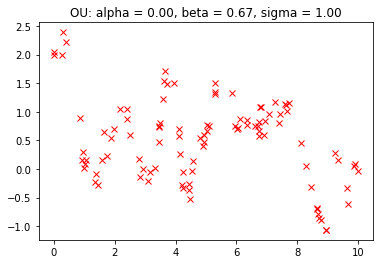

In [190]:
plt.plot(true_sde.pts, true_sde.trj, 'rx')
plt.title("OU: alpha = %.2f" % vi.alpha + ", beta = %.2f" % vi.beta + ", sigma = %.2f" % vi.sigma)
plt.show()

In [192]:
obs = np.random.normal(loc = true_sde.trj[::10], scale = .01)

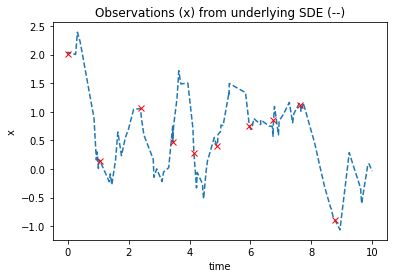

In [244]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts, true_sde.trj, '--')
plt.plot(true_sde.pts[::10], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [260]:
import tqdm as tq

In [261]:
beta_ = 3.

N = 100
learning_rate = 0.0002

trace = []
for i in tq.tqdm(range(300)):
# for i in range(300):
    beta_grad = 0.

    for i in range(N):
        vi = OU(t0 = 0., t1 = 1., z0 = obs[0], alpha = 0 , beta = beta_ , sigma = 1., dN=100)
        elbo = ELBO(vi)
        score = Score(vi)
        
        scores = score.compute_score()
        f_of_X = -1 * (elbo.log_prob(obs[1]) - (elbo.KL_ito() + elbo.KL_rest()))
        assert f_of_X != np.nan, "shit"

        beta_grad += f_of_X * scores['beta']
        
    beta_ -= learning_rate * beta_grad/N

#     print("beta = ", beta_)
    trace.append(beta_.data.cpu().numpy().copy())
# score.compute_score()

100%|████████████████████████████████████████████████| 300/300 [04:47<00:00,  1.04it/s]


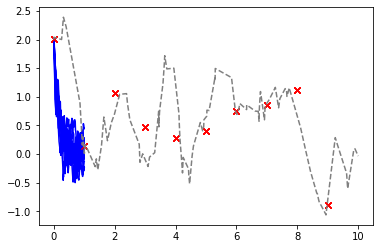

In [262]:
for i in range(10):
    posterior = OU(t0 = 0., t1 = 1., z0 = obs[0], alpha = 0 , beta = beta_ , sigma = 1., dN=100)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

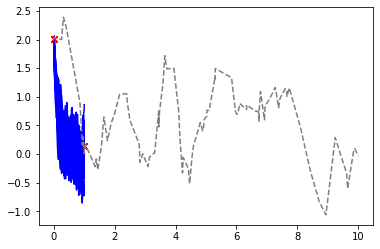

In [263]:
for i in range(50):
    posterior = OU(t0 = 0., t1 = 1., z0 = obs[0], alpha = 0, beta = beta_, sigma = 1., dN=100)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(obs[:2], 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

**Trace plot: gradient**

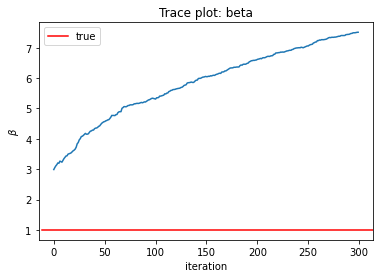

In [264]:
plt.title("Trace plot: beta")
plt.plot(np.arange(len(trace)), trace)
plt.axhline(1.0, xmin=0.01, xmax=300, color='red', label='true')
plt.legend()
plt.xlabel("iteration")
plt.ylabel(r"$\beta$")
plt.show()

**Posterior moment based on the average of last 30 iterations of beta**

In [265]:
def posterior_moment(init, alpha, beta):
    sigma = 1.
    pts = np.linspace(0,1,11)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
        
    for i in range(dt.shape[0]):
        mean.append(alpha + (mean[i] - alpha)*np.exp(-1 * beta * dt[i]))
    
    func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
    sd = list(map(func, dt))
    
    return np.array(mean), np.array(sd)

In [266]:
pmean, psd = posterior_moment(obs[0], 0, beta_.data.numpy())

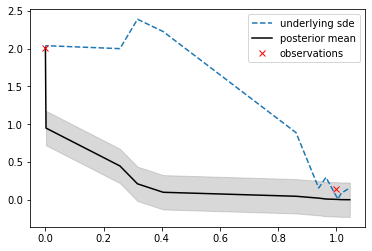

In [267]:
plt.plot(true_sde.pts[:11], true_sde.trj[:11], linestyle='dashed', label='underlying sde')
plt.plot(true_sde.pts[:11], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[1:11], pmean[1:] - psd, pmean[1:] + psd, alpha=0.3, color='grey')
plt.plot(obs[:2], 'rx', label='observations')
plt.legend()
plt.show()

2. Complete piece-wise optimization from t=0 to t=10

We use the posterior mean of the previous step as our initial value for next vi

In [218]:
vi_beta = np.empty(9)

In [219]:
N = 100
learning_rate = 0.0002
z0 = obs[0]

for t in tq.tqdm(range(obs.shape[0]-1)):
    beta_ = np.random.uniform(0, 5)
    
    trace = []
    for i in range(200):
        beta_grad = 0.
            
        for i in range(N):
            vi = OU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0, alpha = 0 , beta = beta_ , sigma = 1., dN=100)
            elbo = ELBO(vi)
            score = Score(vi)

            scores = score.compute_score()
            f_of_X = -1 * (elbo.log_prob(obs[t+1]) - (elbo.KL_ito() + elbo.KL_rest()))
            
            beta_grad += f_of_X * scores['beta']

        beta_ -= learning_rate * beta_grad/N
    #     print("beta = ", beta_)
        trace.append(beta_.data.cpu().numpy().copy())
    
    vi_beta[t] = np.mean(trace[-30:])
    z0 *= np.exp(-1 * vi_beta[t] * (obs_time[t+1] - obs_time[t]))
# score.compute_score()

100%|███████████████████████████████████████████████████| 9/9 [28:08<00:00, 187.65s/it]


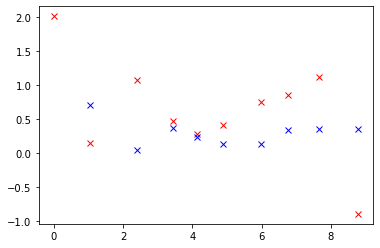

In [243]:
plt.plot(obs_time, obs, 'rx')
plt.plot(obs_time[1:], obs[:-1] * np.exp(-1 * 1 * (obs_time[1:] - obs_time[:-1])), 'bx')

In [238]:
vi_beta

array([7.03579894, 8.15155392, 6.74891346, 6.77036687, 6.87931484,
       6.80301186, 6.44891765, 6.8981344 , 6.48395688, 0.89654582])

In [239]:
obs[:-1] * np.exp(-1 * vi_beta[:-1] * (obs_time[1:] - obs_time[:-1]))

array([1.28360871e-03, 2.57641138e-06, 8.27598097e-04, 4.29516700e-03,
       1.64516610e-03, 2.68598423e-04, 4.56621916e-03, 1.87485191e-03,
       6.91718088e-04])

In [230]:
obs * np.exp(-1 * vi_beta * (obs_time[2] - obs_time[1]))

2.576411381281092e-06

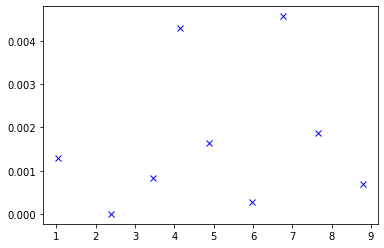

In [242]:
plt.plot(obs_time[1:], obs[:-1] * np.exp(-1 * vi_beta[:-1] * (obs_time[1:] - obs_time[:-1])), 'bx')